In [39]:
%matplotlib inline
import torch
from d2l import torch as d2l


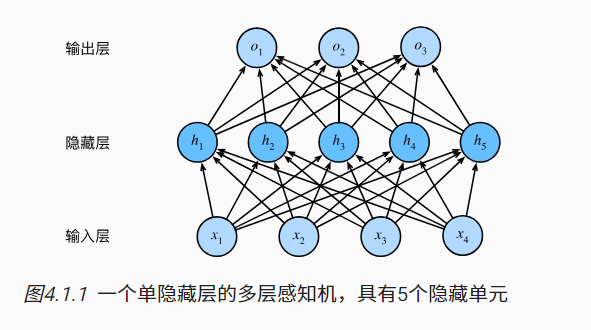

## 4.1.2.1. ReLU函数

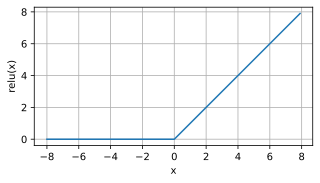

In [40]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

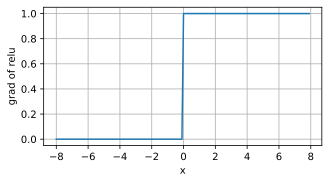

In [41]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))


## 4.1.2.2. sigmoid函数

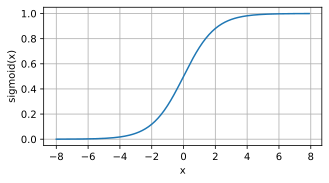

In [42]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

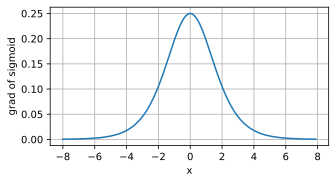

In [43]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))


## 4.1.2.3. tanh函数

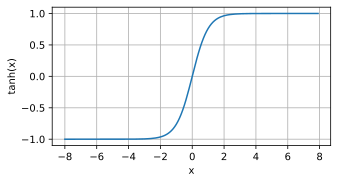

In [44]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

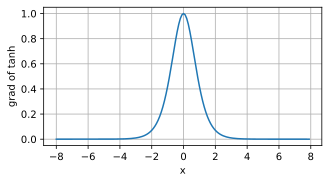

In [45]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## 4.2. 多层感知机的从零开始实现

In [46]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [47]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [48]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
params = [W1, b1, W2, b2]

In [49]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [50]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)
    return (H@W2 + b2)

In [51]:
loss = nn.CrossEntropyLoss(reduction='none')

In [55]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)


In [53]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 4.3. 多层感知机的简洁实现

In [57]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)


In [58]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [59]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [60]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.3974],
         [-1.3982]]),
 tensor([[ 1.0000e+00, -3.9738e-01,  7.8956e-02, -1.0459e-02,  1.0390e-03,
          -8.2578e-05,  5.4691e-06, -3.1048e-07,  1.5422e-08, -6.8095e-10,
           2.7060e-11, -9.7755e-13,  3.2372e-14, -9.8954e-16,  2.8087e-17,
          -7.4410e-19,  1.8481e-20, -4.3199e-22,  9.5370e-24, -1.9947e-25],
         [ 1.0000e+00, -1.3982e+00,  9.7748e-01, -4.5557e-01,  1.5924e-01,
          -4.4531e-02,  1.0377e-02, -2.0727e-03,  3.6226e-04, -5.6279e-05,
           7.8690e-06, -1.0002e-06,  1.1654e-07, -1.2534e-08,  1.2518e-09,
          -1.1669e-10,  1.0197e-11, -8.3867e-13,  6.5145e-14, -4.7940e-15]]),
 tensor([ 4.1598, -2.4806]))

In [61]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [62]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())


In [33]:
import d2l
dir(d2l)


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'torch']

In [ ]:
Name: d2l
Version: 1.0.0
Summary: Dive into Deep Learning Libraries
...
